# **ML project - Predicting good tippers among taxi clients**


In this scenario, the New York City Taxi & Limousine Commission (New York City TLC) has requested that you build a machine learning model to predict if a customer will not leave a tip. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.


# Build a machine learning model

In this activity, we will practice using tree-based modeling techniques to predict on a binary target class.  
<br/>   

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  
<br/>  

*This activity has three parts:*

**Part 1:** Ethical considerations 
* Consider the ethical implications of the request 

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps




# Build a machine learning model

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="images/Plan.png" width="100" height="100" align=left>


## PACE: Plan 





1. The purpose is to build a random forest model to predict whether a customer is likely to give a generous tip. The objectif is to help drivers maximize their income.
2. While the objective itself is good, the result of model could be used at the expense of customers interest. Some customers might end up beeing simply denied access to transportation services because they are predicted to be bad tippers. Moreover, some good tippers (false positives) might be denied service too.
3. If carefully managed, I think the benefits of such a model can outweight its potential problems, since it will help drivers maximize their revenues. However, if the percentage of generous tippers is low, the model will lead drivers to avoid bad tippers (who are in majority), dramatically shrinking their overall market size.

Let's suppose that instead of predicting people who won't tip at all, we predict people who are particularly generous&mdash;those who will tip 20% or more. 


**First thoughts:**
1. All features might be potential predictors, except ID features
2. The target variable would a calculated feature (=1 if tip/fare >= 0.2, =0 otherwise)
3. Confusion matrix and related metrics such precision, recall, accuracy, and F1 score, can be used to evaluate the model. Those metrics can be calculated only after the model is trained.

### **Task 1. Imports and data loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
# Import packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import pickle

In [2]:
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

Begin by reading in the data. There are two dataframes: one containing the original data, the other containing the mean durations, mean distances, and predicted fares from the previous course's project called nyc_preds_means.csv.


In [3]:
# RUN THE CELL BELOW TO IMPORT YOUR DATA. 

# Load dataset into dataframe
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

Inspect the first few rows of `df0`.


In [4]:
# Inspect the first few rows of df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


Inspect the first few rows of `nyc_preds_means`.

In [5]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


#### Join the two dataframes

Join the two dataframes

In [6]:
# Merge datasets
df1=pd.merge(df0,nyc_preds_means,left_index=True, right_index=True)

<img src="images/Analyze.png" width="100" height="100" align=left>

## PACE: **Analyze**



### **Task 2. Feature engineering**


Call `info()` on the new combined dataframe.

In [7]:
#==> ENTER YOUR CODE HERE
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

We know from EDA (performed prior to this project) that customers who pay cash generally have a tip amount of $0 (probably because it is not tracked). To meet the modeling objective, we'll need to sample the data to select only the customers who pay with credit card. 



In [8]:
# Subset the data to isolate only customers who paid by credit card
df1 = df1[df1['payment_type']==1]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15265 non-null  int64  
 1   VendorID               15265 non-null  int64  
 2   tpep_pickup_datetime   15265 non-null  object 
 3   tpep_dropoff_datetime  15265 non-null  object 
 4   passenger_count        15265 non-null  int64  
 5   trip_distance          15265 non-null  float64
 6   RatecodeID             15265 non-null  int64  
 7   store_and_fwd_flag     15265 non-null  object 
 8   PULocationID           15265 non-null  int64  
 9   DOLocationID           15265 non-null  int64  
 10  payment_type           15265 non-null  int64  
 11  fare_amount            15265 non-null  float64
 12  extra                  15265 non-null  float64
 13  mta_tax                15265 non-null  float64
 14  tip_amount             15265 non-null  float64
 15  to

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what we need to create the target variable. We'll have to engineer it. 

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal. 



In [9]:
# Create tip % col
df1['tip_percent'] = np.round(df1['tip_amount']/(df1['total_amount'] - df1['tip_amount']),3)
df1['tip_percent']

0        0.200
1        0.238
2        0.199
3        0.300
5        0.200
         ...  
22692    0.200
22693    0.200
22695    0.250
22697    0.150
22698    0.199
Name: tip_percent, Length: 15265, dtype: float64

Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [10]:
# Create 'generous' col (target)
#==> ENTER YOUR CODE HERE
df1['generous'] = df1['tip_percent']>=0.2
df1['generous'].astype(int)


0        1
1        1
2        0
3        1
5        1
        ..
22692    1
22693    1
22695    1
22697    0
22698    0
Name: generous, Length: 15265, dtype: int32

#### Create day column

Next, we're going to be working with the pickup and dropoff columns.

Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [11]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'])

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [12]:
#### Create a 'day' col
#==> ENTER YOUR CODE HERE
df1['day'] = df1['tpep_pickup_datetime'].apply(lambda x: x.strftime('%A').lower())
df1['day']

0        saturday
1         tuesday
2          friday
3          sunday
5        saturday
           ...   
22692      sunday
22693    thursday
22695      sunday
22697    saturday
22698    thursday
Name: day, Length: 15265, dtype: object

#### Create time of day columns

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [13]:
# Create 'am_rush' col
#==> ENTER YOUR CODE HERE
df1['am_rush'] = ((df1['tpep_pickup_datetime'].dt.hour >= 6) &
                 (df1['tpep_pickup_datetime'].dt.hour < 10)).astype(int)
# Create 'daytime' col
#==> ENTER YOUR CODE HERE
df1['daytime'] = ((df1['tpep_pickup_datetime'].dt.hour >= 10) &
                 (df1['tpep_pickup_datetime'].dt.hour < 16)).astype(int)
# Create 'pm_rush' col
#==> ENTER YOUR CODE HERE
df1['pm_rush'] = ((df1['tpep_pickup_datetime'].dt.hour >= 16) &
                 (df1['tpep_pickup_datetime'].dt.hour < 20)).astype(int)
# Create 'nighttime' col
#==> ENTER YOUR CODE HERE
df1['nighttime'] = ((df1['tpep_pickup_datetime'].dt.hour >= 20) |
                 (df1['tpep_pickup_datetime'].dt.hour < 6)).astype(int)

df1.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.00,0.3,16.56,22.847222,3.521667,16.434245,0.200,True,saturday,1,0,0,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.00,0.3,20.80,24.470370,3.108889,16.052218,0.238,True,tuesday,0,1,0,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.250000,0.881429,7.053706,0.199,False,friday,1,0,0,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,3.700000,18.731650,0.300,True,sunday,0,1,0,0
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.00,0.3,12.36,11.855376,2.052258,10.441351,0.200,True,saturday,0,0,0,1
6,37660487,2,2017-05-03 19:04:09,2017-05-03 20:03:47,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.00,0.3,59.16,59.633333,12.830000,45.374542,0.200,True,wednesday,0,0,1,0
7,69059411,2,2017-08-15 17:41:06,2017-08-15 18:03:05,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.00,0.3,19.58,26.437500,4.022500,18.555128,0.100,False,tuesday,0,0,1,0
9,95294817,1,2017-11-10 15:20:29,2017-11-10 15:40:55,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.00,0.3,16.55,10.541111,1.580000,9.122755,0.199,False,friday,0,1,0,0
10,18017909,2,2017-03-04 11:58:00,2017-03-04 12:13:12,1,1.77,1,N,162,142,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76,14.178333,1.641000,10.147760,0.200,True,saturday,0,1,0,0
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,40.500000,19.211667,52.000000,0.250,True,sunday,0,0,1,0


#### Create `month` column

Now, create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

<details>
  <summary><h5>HINT</h5></summary>

Refer to the [strftime cheatsheet](https://strftime.org/) for help.
</details>

In [14]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].apply(lambda x: x.strftime('%b').lower())
df1['month']

0        mar
1        apr
2        dec
3        may
5        mar
        ... 
22692    jul
22693    aug
22695    aug
22697    jul
22698    mar
Name: month, Length: 15265, dtype: object

Examine the first five rows of your dataframe.

In [15]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,True,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,True,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,False,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,True,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,True,saturday,0,0,0,1,mar


#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [16]:
# Drop columns
df1.dtypes
df2 = df1.drop(columns=['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'payment_type', 'trip_distance', 'tip_amount', 'tip_percent', 'total_amount', 'tolls_amount'], axis=1)

#### Variable encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.


In [17]:
# 1. Define list of cols to convert to string
cols_to_str = ['VendorID','RatecodeID', 'PULocationID', 'DOLocationID']
# 2. Convert each column to string
for y in cols_to_str:
    df2[y]=df2[y].apply(lambda x: str(x))
    
df2.dtypes

VendorID                  object
passenger_count            int64
RatecodeID                object
store_and_fwd_flag        object
PULocationID              object
DOLocationID              object
fare_amount              float64
extra                    float64
mta_tax                  float64
improvement_surcharge    float64
mean_duration            float64
mean_distance            float64
predicted_fare           float64
generous                    bool
day                       object
am_rush                    int32
daytime                    int32
pm_rush                    int32
nighttime                  int32
month                     object
dtype: object


<details>
  <summary><h5>HINT</h5></summary>

To convert to string, use `astype(str)` on the column.
</details>

Now convert all the categorical columns to binary.

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df2`.


In [18]:
# Convert categoricals to binary
df2 = pd.get_dummies(df2)
df2.head()

,passenger_count,fare_amount,extra,mta_tax,improvement_surcharge,mean_duration,mean_distance,predicted_fare,generous,am_rush,daytime,pm_rush,nighttime,VendorID_1,VendorID_2,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_99,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_1,PULocationID_10,PULocationID_100,PULocationID_106,PULocationID_107,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_116,PULocationID_12,PULocationID_123,PULocationID_125,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_13,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_137,PULocationID_138,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_148,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_158,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_166,PULocationID_17,PULocationID_170,PULocationID_173,PULocationID_179,PULocationID_181,PULocationID_186,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_193,PULocationID_196,PULocationID_208,PULocationID_209,PULocationID_211,PULocationID_213,PULocationID_216,PULocationID_218,PULocationID_223,PULocationID_224,PULocationID_225,PULocationID_226,PULocationID_229,PULocationID_230,PULocationID_231,PULocationID_232,PULocationID_233,PULocationID_234,PULocationID_236,PULocationID_237,PULocationID_238,PULocationID_239,PULocationID_24,PULocationID_243,PULocationID_244,PULocationID_246,PULocationID_247,PULocationID_249,PULocationID_25,PULocationID_255,PULocationID_256,PULocationID_258,PULocationID_260,PULocationID_261,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,PULocationID_28,PULocationID_33,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_4,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_45,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_52,PULocationID_57,PULocationID_61,PULocationID_62,PULocationID_65,PULocationID_66,PULocationID_68,PULocationID_7,PULocationID_70,PULocationID_74,PULocationID_75,PULocationID_79,PULocationID_80,PULocationID_82,PULocationID_87,PULocationID_88,PULocationID_90,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_95,PULocationID_97,DOLocationID_1,DOLocationID_10,DOLocationID_100,DOLocationID_102,DOLocationID_106,DOLocationID_107,DOLocationID_11,DOLocationID_112,DOLocationID_113,DOLocationID_114,DOLocationID_116,DOLocationID_117,DOLocationID_118,DOLocationID_119,DOLocationID_12,DOLocationID_120,DOLocationID_121,DOLocationID_123,DOLocationID_124,DOLocationID_125,DOLocationID_126,DOLocationID_127,DOLocationID_129,DOLocationID_13,DOLocationID_130,DOLocationID_131,DOLocationID_132,DOLocationID_133,DOLocationID_134,DOLocationID_135,DOLocationID_136,DOLocationID_137,DOLocationID_138,DOLocationID_14,DOLocationID_140,DOLocationID_141,DOLocationID_142,DOLocationID_143,DOLocationID_144,DOLocationID_145,DOLocationID_146,DOLocationID_147,DOLocationID_148,DOLocationID_15,DOLocationID_151,DOLocationID_152,DOLocationID_153,DOLocationID_157,DOLocationID_158,DOLocationID_159,DOLocationID_16,DOLocationID_160,DOLocationID_161,DOLocationID_162,DOLocationID_163,DOLocationID_164,DOLocationID_166,DOLocationID_168,DOLocationID_169,DOLocationID_17,DOLocationID_170,DOLocationID_173,DOLocationID_174,DOLocationID_175,DOLocationID_177,DOLocationID_178,DOLocationID_179,DOLocationID_180,DOLocationID_181,DOLocationID_182,DOLocationID_183,DOLocationID_186,DOLocationID_188,DOLocationID_189,DOLocationID_19,DOLocationID_192,DOLocationID_193,DOLocationID_194,DOLocationID_195,DOLocationID_196,DOLocationID_197,DOLocationID_198,DOLocationID_200,DOLocationID_202,DOLocationID_208,DOLocationID_209,DOLocationID_21,DOLocationID_210,DOLocationID_211,DOLocationID_212,DOLocationID_213,DOLocationID_216,DOLocationID_217,DOLocationID_218,DOLocationID_22,DOLocationID_220,DOLocationID_223,DOLocati

##### Evaluation metric

Before modeling, you must decide on an evaluation metric. 

1. Examine the class balance of your target variable. 

In [19]:
# Get class balance of 'generous' col
df2['generous'].value_counts()

True     8035
False    7230
Name: generous, dtype: int64

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. You want to help taxi drivers make more money, but you don't want this to anger customers. Your metric should weigh both precision and recall equally.** 

The most relevant metric is **F1 score**, the harmonic mean between precision and recall.

<img src="images/Construct.png" width="100" height="100" align=left>

## PACE: **Construct**



### **Task 3. Modeling**

##### **Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/testing data. 

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [20]:
# Isolate target variable (y)
y=df2['generous']
# Isolate the features (X)
X = df2.drop('generous', axis=1)
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

##### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)


**Note:** `refit` should be set to `'f1'`.<font/>
</details>
 


In [28]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)
# 2. Create a dictionary of hyperparameters to tune 
cv_params = {
    'max_depth':[2,3,5],
    'max_features':[5,10,15],
    'max_samples':[2000,3000,4000],
    'min_samples_leaf':[1,2,4],
    'min_samples_split':[2,4,5],
    'n_estimators':[100,125,200],
}
# 3. Define a set of scoring metrics to capture
scoring = {'precision', 'recall', 'accuracy','f1'}
# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

Now fit the model to the training data. 

In [30]:
%%time

#rf_cv.fit(X_train, y_train)

CPU times: total: 12min 37s
Wall time: 21min 41s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 5], 'max_features': [5, 10, 15],
                         'max_samples': [2000, 3000, 4000],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 5],
                         'n_estimators': [100, 125, 200]},
             refit='f1', scoring={'precision', 'f1', 'accuracy', 'recall'})

Let's use `pickle` to save our models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [31]:
import pickle 

# Define a path to the folder where you want to save the model
path = 'D:/Portfolio/Automatidata Project NYC TLC data/'

In [32]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

write_pickle(path,rf_cv,'project_rf_cv')

In [33]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model
    
rf_cv = read_pickle(path, 'project_rf_cv')

Examine the best average score across all the validation folds. 

In [34]:
# Examine best score
rf_cv.best_score_

0.7538011709445405

Examine the best combination of hyperparameters.

In [35]:
rf_cv.best_estimator_

RandomForestClassifier(max_depth=5, max_features=5, max_samples=4000,
                       min_samples_leaf=4, n_estimators=200, random_state=0)

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

<details>
  <summary><h5>HINT</h5></summary>

To learn more about how this function accesses the cross-validation results, refer to the [`GridSearchCV` scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) for the `cv_results_` attribute.

</details>

In [36]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

Call `make_results()` on the GridSearch object.

In [59]:
#==> ENTER YOUR CODE HERE
results = make_results('Random Forest CV', rf_cv, 'f1')
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.690726,0.829653,0.753801,0.714788


Results should produce an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable, but this is always dependent on the use case. 


Use the model to predict on the test data. Assign the results to a variable called `rf_preds`.

In [38]:
# Get scores on test data
rf_preds = rf_cv.best_estimator_.predict(X_test)
rf_preds

array([ True, False, False, ..., False, False, False])

Use the below `get_test_scores()` function you will use to output the scores of the model on the test data.

In [39]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `rf_test_scores`.
2. Call `rf_test_scores` to output the results.

###### RF test results

In [60]:
 # Get scores on test data
rf_test_scores = get_test_scores('Random Forest test', rf_preds, y_test)
results  = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.690726,0.829653,0.753801,0.714788
0,Random Forest test,0.680884,0.824518,0.745849,0.704225


**Question:** How do your test results compare to your validation results?


Scores are slightly lower, which is normal.

##### **XGBoost**

 Try to improve your scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [49]:
# 1. Instantiate the XGBoost classifier
#==> ENTER YOUR CODE HERE
xgb = XGBClassifier(random_state=0)

# 2. Create a dictionary of hyperparameters to tune
#==> ENTER YOUR CODE HERE
cv_params = {
    'max_depth':[5,7,10],
    'min_child_weight':[1,3,5],
    'learning_rate':[5,7,10],
    'n_estimators':[50,100,200],
}
# 3. Define a set of scoring metrics to capture
#==> ENTER YOUR CODE HERE
scoring = {'precision', 'recall', 'accuracy','f1'}

# 4. Instantiate the GridSearchCV object
#==> ENTER YOUR CODE HERE
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [50]:
%%time
xgb_cv.fit(X_train, y_train)

C:\Users\excel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\excel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\excel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\excel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

CPU times: total: 20min 5s
Wall time: 2min 47s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

Get the best score from this model.

In [55]:
# Examine best score
#==> ENTER YOUR CODE HERE
xgb_cv.best_score_

0.743408667496402

And the best parameters.

In [56]:
# Examine best parameters
#==> ENTER YOUR CODE HERE
xgb_cv.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

##### XGB CV Results

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [62]:
# Call 'make_results()' on the GridSearch object
#==> ENTER YOUR CODE HERE
res_xgb = make_results('XGBoost CV', xgb_cv, 'f1')
results = pd.concat([results, res_xgb], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.690726,0.829653,0.753801,0.714788
0,Random Forest test,0.680884,0.824518,0.745849,0.704225
0,XGBoost CV,0.659676,0.866975,0.743409,0.679735


Use your model to predict on the test data. Assign the results to a variable called `xgb_preds`.

<details>
  <summary><h5>HINT</h5></summary>
    
You cannot call `predict()` on the GridSearchCV object directly. You must call it on the `best_estimator_`.
</details>

In [58]:
# Get scores on test data
xgb_preds = xgb_cv.best_estimator_.predict(X_test)
xgb_preds

array([0, 0, 0, ..., 0, 0, 0])

###### XGB test results

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_test_scores`.
2. Call `xgb_test_scores` to output the results.

In [63]:
# Get scores on test data
#==> ENTER YOUR CODE HERE
xgb_test_scores = get_test_scores('XGBoost test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.690726,0.829653,0.753801,0.714788
0,Random Forest test,0.680884,0.824518,0.745849,0.704225
0,XGBoost CV,0.659676,0.866975,0.743409,0.679735
0,XGBoost test,0.637255,0.040448,0.076068,0.482804


**Question:** Compare these scores to the random forest test scores. What do you notice? Which model would you choose?

Random forest model appears to be performing much better than XGBoost model. We will then continue with the random forest model.

Plot a confusion matrix of the model's predictions on the test data.

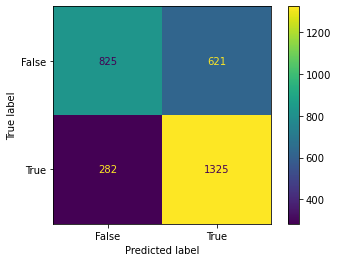

In [66]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels =rf_cv.classes_)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = rf_cv.classes_)
disp.plot(values_format = '')

**Question:** What type of errors are more common for your model?

The model is more than twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. From the point of view of the drivers, this is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory.

##### Feature importance

Use the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones.

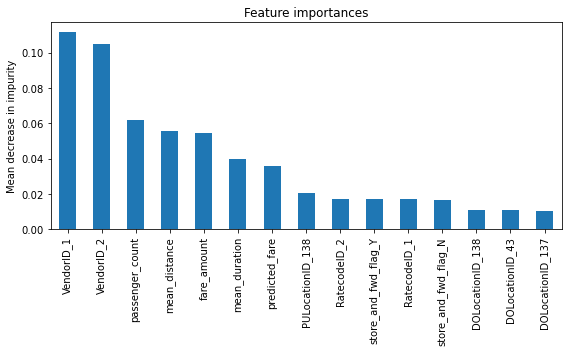

In [67]:
importances = rf_cv.best_estimator_.feature_importances_

#rf_importances = pd.Series(importances, index=X_test.columns)
#rf_importances = rf_importances.sort_values(ascending=False)[:15]

#fig, ax = plt.subplots(figsize=(8,5))
#rf_importances.plot.bar(ax=ax)
#ax.set_title('Feature importances')
#ax.set_ylabel('Mean decrease in impurity')
#fig.tight_layout();

<img src="images/Execute.png" width="100" height="100" align=left>

## PACE: **Execute**

Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 4. Conclusion**

Thought not perfect,this model performed relativement. Its F<sub>1</sub> score was 0.7458 and it had an overall accuracy of 0.7042. It correctly identified ~82% of the actual generous tippers in the test set, which is way better than a random guess. 

The most predictive features seemed to be VendorID, passenger counts, mean distance and fare amount.

As a next step, it may be worthwhile to test the model with a select group of taxi drivers to get feedback. It would also be recommanded to gather more data including past tipping behaviours and tips given by clients who pay by cash.